# Integrating GPU libraries for fun and profit

### ...on extending and interfacing HPC simulation tools

##### Authors: Adrian Oeftiger and Martin Schwinzerl

# Abstract

I have a high-performance number crunching tool with cool physics which simulates long-term on a GPU &ndash; how can I extend the inner loop by further cool physics, injected from the outside?
In python this should be easy, right? But wait... we are sitting on device memory?

In this talk we explore how to tightly couple two libraries for high-performance computation of long-term beam dynamics, `SixTrackLib` and `PyHEADTAIL`. How can we design the _interface_ between both libraries in terms of

(1) remaining on the python level,

(2) avoid losing performance due to device-to-host-to-device copies, and

(3) keeping both libraries as stand-alone packages?

The interface can be surprisingly simple, yet fully fledged... Let's go!

# ... the physics ...

# Collective beam dynamics

3D particle motion $\leadsto$ 6 phase space coordinates:
$$\mathbb{X}=(\underbrace{x, x'\vphantom{y'}}_{horizontal}, \underbrace{y, y'}_{vertical}, \underbrace{z, \delta\vphantom{y'}}_{longitudinal})$$

A beam $=$ state of $N$ macro-particles $=$ $6N$ values of phase space coordinates

## Simulations:
* typically up to $\mathcal{O}(10^6)$ macro-particles
* accelerator elements to track through: up to $\mathcal{O}(1000)$
* simulations can last up to $\mathcal{O}(10^6)$ turns 
* particle-to-particle interaction: binning, FFT, convolution, particle-in-cell, Poisson solvers

# Requirements for simulation tools

* long-term evolution $\leadsto$ **double precision**
* heavy **number crunching** $\leadsto$ high-performance computing (**HPC**)<br />(in particular for _collective effects_ i.e. particle-to-particle interaction)
* **iterative development**, frequent update of accelerator models $\leadsto$ python

# Single-particle vs. multi-particle dynamics

**single-particle** $\implies$ <span style="color:#00aad4;">"tracking"</span>: particle motion due to external focusing (magnets and RF cavities)

**multi-particle** $\implies$ <span style="color:#aa0000;">"collective effect kicks"</span>: direct and indirect particle-to-particle interaction

<center>
<img src="images/transverse-model_empty.png" alt="sketch of one-turn map for ring" style="width:30%;"/>
Tracking around the accelerator ring
</center>

# The `PyHEADTAIL` library

Python based code for simulating collective beam dynamics: [github repo $\nearrow$](https://github.com/PyCOMPLETE/PyHEADTAIL)

$\implies$ simplified matrix-based <span style="color:#00aad4;">tracking</span>

$\implies$ **strong:** detailed models for <span style="color:#aa0000;">collective effect kicks</span>

<center>
<img src="images/wakefield.png" alt="wake field sketch" style="width:30%;"/>
Example for a kick: wakefield induced by leading particles imparting kicks on trailing particles
</center>

# The `SixTrackLib` library

C templated code with Python API for simulating single-particle beam dynamics: [github repo $\nearrow$](https://github.com/sixtrack/sixtracklib)

$\implies$ **strong:** advanced non-linear <span style="color:#00aad4;">tracking</span>

$\implies$ approximative / simplified models for <span style="color:#aa0000;">collective effect kicks</span>

<center>
<img src="images/tracking.png" alt="tracking sketch" style="width:30%;"/>
Example for tracking: <span style="color:#ff6701;">dipole magnets bend</span> and <span style="color:#800000;">quadrupole magnets (de-)</span><span style="color:#000080;">focus</span> particles
</center>

# ... the HPC part ...

# `PyHEADTAIL` on the GPU

[Concept presented on PyHEP'19 $\nearrow$](https://indico.cern.ch/event/833895/contributions/3577801/), in short:

<div style="float: right; width: 10%">
<img src="images/duck.png" alt="duck typing" style="width: 100%;" /> <br />
<!-- <img src="pycuda-logo2.png" alt="PyCUDA logo" style="width: 100%;" /> -->
</div>

* utilise **duck typing** to separate physics from back-end implementation
* sandwich layer via **context management** and **function redirection**<br />(separate math dictionaries for CPU and GPU)
* exploit GPU via `PyCUDA` (`CuPy` would work similarly)

```python
# tracking loop in PyHEADTAIL:
with GPU(pyht_beam):
    for i in range(n_turns):
        for element in pyht_ring_elements:
            element.track(pyht_beam)
```

$\implies$ implement physics only once! <br />
$\implies$ back-end details transparent to users / high-level developers

# `SixTrackLib` on the GPU

[Concept presented on PyHEP'19 $\nearrow$](https://indico.cern.ch/event/833895/contributions/3577803/), in short:

* Python API for dynamic interaction
* C **templating approach** to separate physics from back-end implementation
    * implementation in usual C for (single-core) CPU
    * implementation in openCL for multi-core CPU and GPU (AMD, NVIDIA)
    * implementation in CUDA for NVIDIA GPUs

```python
# tracking kernel in SixTrackLib
trackjob = stl.TrackJob(stl_ring_elements, stl_beam, device='opencl:0.0')
trackjob.track_until(n_turns)
```

$\implies$ implement physics only once! <br />
$\implies$ users launch "trackjobs" with just a single `device` keyword to switch architecture

# ... the quest ...

# `SixTrackLib` $+$ `PyHEADTAIL` $=$ <3 ?

`SixTrackLib` $\rightarrow$ strong in advanced non-linear <span style="color:#00aad4;">tracking</span>

`PyHEADTAIL` $\rightarrow$ strong in <span style="color:#aa0000;">collective effect kicks</span>

$\implies$ `SixTrackLib` $+$ `PyHEADTAIL` $=$ strong in both?

<center>
<img src="images/transverse-model_integration.png" alt="integrating PyHEADTAIL and SixTrackLib" style="width:30%;"/>
Alternating SixTrackLib <span style="color:#00aad4;">tracking</span> and PyHEADTAIL <span style="color:#aa0000;">kicking</span>
</center>

# ... the quest*ions* ...

Situation:
* `PyHEADTAIL` on the GPU lives in `PyCUDA`, managed from user script
* `SixTrackLib` on the GPU manages its CUDA kernel invocation by itself
* beam state data: <br />`PyHEADTAIL` uses `PyCUDA.GPUArrays` while `SixTrackLib` uses custom memory buffers

Critical aspects:
* how to hand over the data between the two codes?
* how to avoid GPU - CPU - GPU memory transfer?
* can `PyHEADTAIL`'s `PyCUDA` context interact with `SixTrackLib`'s initialised context? 
    * visibility of memory to each other
    * alternating kernel calls?
    * flow control from python level?

# ... example simulation with `PyHEADTAIL` ...

## ... a coherent instability in the LHC ...

In [1]:
# set up plotting, pythonpath etc
from imports import *

from scipy.constants import m_p, c, e

Importing PyHEADTAIL:

In [2]:
# initialise CUDA context for PyHEADTAIL via pycuda
from pycuda import driver
context = driver.Device(0).make_context()

import PyHEADTAIL

import pyht_streamless_slicing

PyHEADTAIL v1.14.1.18




# Setting up <span style="color:#00aad4;">tracking</span> around the LHC ring

Transverse tracking:

In [3]:
from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.trackers.detuners import Chromaticity

from pyheadtail_setup import transverse_map_kwargs, Q_x, Q_y

In [4]:
transverse_map = TransverseMap(
#     detuners=[Chromaticity(10, 10)],
    **transverse_map_kwargs,
)

Longitudinal tracking:

In [5]:
from PyHEADTAIL.trackers.longitudinal_tracking import RFSystems

from pyheadtail_setup import longitudinal_map_kwargs

In [6]:
longitudinal_map = RFSystems(**longitudinal_map_kwargs)

# Setting up <span style="color:#aa0000;">collective effect kick</span>

Simulate wakefields in bunch via broad-band resonator:

In [7]:
from PyHEADTAIL.impedances.wakes import WakeField, CircularResonator
from PyHEADTAIL.particles.slicing import UniformBinSlicer

In [8]:
# responsible for binning the beam longitudinally:
slicer = UniformBinSlicer(n_slices=50, n_sigma_z=4)

# wakefield kick
resonator_wake = CircularResonator(
    R_shunt=100e6, frequency=0.8e9, Q=1,
)
wakefield = WakeField(slicer, resonator_wake)

<center>
<img src="images/wakefield.png" alt="wake field sketch" style="width:20%;"/>
</center>

# Assembling the transport map around the LHC ring:

In [9]:
pyht_ring_elements = list(transverse_map) + [longitudinal_map, wakefield]

<center>
    <!--<img src="images/SIS100.jpg" alt="SIS100 layout" style="width: 40%;" />-->
    <img src="images/lhc.jpg" alt="LHC" style="width: 40%;" />
</center>
<center>
    <span style="font-size: 0.7em;">image reference: CMS-doc-5740-v1</span>
</center>

# Initialising the particle bunch

6D Gaussian distribution:

In [10]:
from PyHEADTAIL.particles.generators import generate_Gaussian6DTwiss

from pyheadtail_setup import beam_kwargs

In [11]:
n_macroparticles = 10000
intensity = 1e11 * 5

np.random.seed(0)

pyht_beam = generate_Gaussian6DTwiss(
    macroparticlenumber=n_macroparticles,
    intensity=intensity,
    **beam_kwargs,
    **transverse_map.get_injection_optics(
        for_particle_generation=True),
)

A nicely Gaussian distributed bunch:

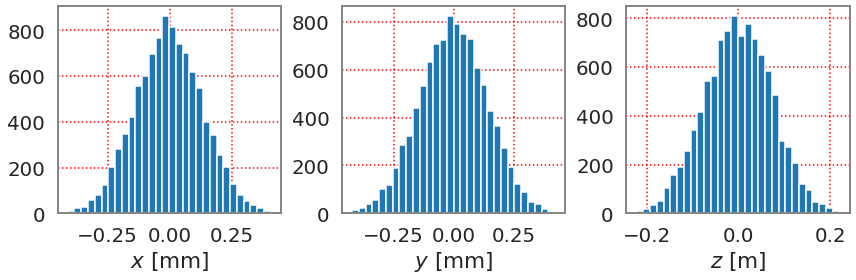

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
plt.sca(ax[0])
plt.xlabel('$x$ [mm]')
plt.hist(pyht_beam.x * 1e3, bins=30);

plt.sca(ax[1])
plt.xlabel('$y$ [mm]')
plt.hist(pyht_beam.y * 1e3, bins=30);

plt.sca(ax[2])
plt.xlabel('$z$ [m]')
plt.hist(pyht_beam.z, bins=30);
plt.tight_layout()

Initial vertical bunch offset:

In [13]:
pyht_beam.y += 0.1 * pyht_beam.sigma_y()

Storing a blueprint of the initial bunch state for later:

In [14]:
slices0 = pyht_beam.get_slices(slicer, statistics=['mean_y'])

# Let's go &ndash; simulating the LHC in `PyHEADTAIL` on the GPU:

In [15]:
from PyHEADTAIL.general.contextmanager import CPU, GPU
from PyHEADTAIL.general import pmath

In [16]:
n_turns = 500

# transfer to GPU
with GPU(pyht_beam):
    my = pmath.zeros(n_turns, dtype=float)
    
    # loop over turns
    for i in range(n_turns):
        # loop over elements around ring
        for element in pyht_ring_elements:
            element.track(pyht_beam)

        # record vertical bunch centroid amplitude
        my[i] = pyht_beam.mean_y()

In [17]:
my = pmath.ensure_CPU(my)

# Outcome of our simulation?

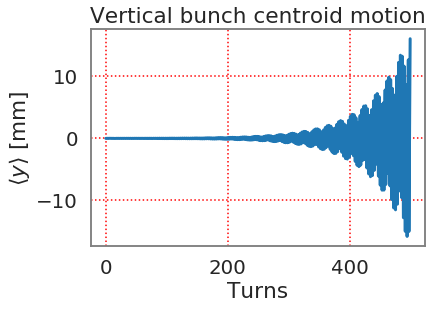

In [18]:
plt.plot(my * 1e3)
plt.xlabel('Turns')
plt.ylabel(r'$\langle y \rangle$ [mm]')
plt.title('Vertical bunch centroid motion');

$\leadsto$ centre-of-mass of the bunch grows exponentially $\implies$ instability!

This _transverse mode coupling instability_ develops along the bunch:

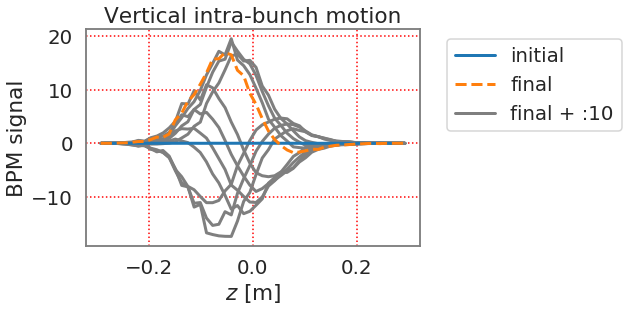

In [19]:
from imports import plot_intrabunch

plot_intrabunch(pyht_ring_elements, pyht_beam, slicer, slices0)

The LHC accelerator layout ("lattice") was simulated with a **simple matrix tracking** model in `PyHEADTAIL`.

In [20]:
pyht_beam = generate_Gaussian6DTwiss(
    macroparticlenumber=n_macroparticles,
    intensity=intensity,
    **beam_kwargs,
    **transverse_map.get_injection_optics(
        for_particle_generation=True),
)

In [21]:
pyht_ring_elements = list(transverse_map) + [longitudinal_map] # no wakefield

In [22]:
n_turns = 200

# transfer to GPU
with GPU(pyht_beam):
    sx = pmath.zeros(n_turns, dtype=float)
    
    # loop over turns
    for i in range(n_turns):
        # loop over elements around ring
        for element in pyht_ring_elements:
            element.track(pyht_beam)

        # record horizontal bunch size oscillation
        sx[i] = pyht_beam.sigma_x()

In [23]:
sx = pmath.ensure_CPU(sx)

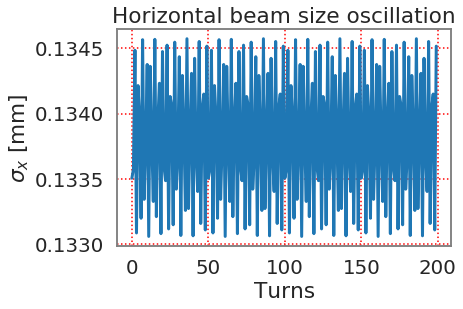

In [24]:
plt.plot(sx * 1e3)
plt.xlabel('Turns')
plt.ylabel('$\sigma_x$ [mm]')
plt.title('Horizontal beam size oscillation');

... `SixTrackLib` can simulate the real lattice... shall we?

# ... example simulation with `SixTrackLib` ...

## ... tracking around the LHC ...

Importing SixTrackLib:

In [25]:
import sixtracklib as stl

In [26]:
# in absence of versioning, print current git commit for reference
import os
stl_dir = os.path.dirname(stl.__file__)
!printf "SixTrackLib " && cd $stl_dir && git log | head -1

SixTrackLib commit 947643d56dd16b0106f9efd71510053bceef8c2d


# Load the LHC lattice

In [27]:
stl_ring_elements = stl.Elements.fromfile(
    stl_dir + '/../../tests/testdata/lhc_no_bb/beam_elements.bin')

And add a monitor to record the motion of particles later when the tracking kernel is dispatched:

In [28]:
n_macroparticles = 1000
n_turns = 200

stl_ring_elements.BeamMonitor(
    start=0, num_stores=n_turns, max_particle_id=n_macroparticles - 1);

# Initialise another `PyHEADTAIL` bunch...

In [29]:
np.random.seed(0)

pyht_beam = generate_Gaussian6DTwiss(
    macroparticlenumber=n_macroparticles,
    intensity=0,
    # the injection optics for this LHC lattice:
    alpha_x=2.2,
    beta_x=117,
    dispersion_x=-0.41,
    alpha_y=-2.7,
    beta_y=218,
    dispersion_y=-0.047,
    **beam_kwargs,
)

# ... and transfer the bunch to `SixTrackLib`

Initialise `SixTrackLib` particles object:

In [30]:
stl_beam = stl.Particles.from_ref(
    n_macroparticles, p0c=pyht_beam.p0 * c / e, 
    mass0=pyht_beam.mass * c**2 / e, q0=1)

And transfer `PyHEADTAIL` bunch coordinate arrays:

In [31]:
stl_beam.x[:] = pyht_beam.x
stl_beam.px[:] = pyht_beam.xp
stl_beam.y[:] = pyht_beam.y
stl_beam.py[:] = pyht_beam.yp
stl_beam.zeta[:] = pyht_beam.z
stl_beam.delta[:] = pyht_beam.dp

Actually, `SixTrackLib` particles hold a few more longitudinal coordinates just for convenience / rapid computation:

In [32]:
p0 = pyht_beam.p0
beta = pyht_beam.beta

restmass = pyht_beam.mass * c**2
restmass_sq = restmass**2
E0 = np.sqrt((p0 * c)**2 + restmass_sq)
p = p0 * (1 + pyht_beam.dp)
E = np.sqrt((p * c)**2 + restmass_sq)

gammai = E / restmass
betai = np.sqrt(1 - 1. / (gammai * gammai))

We also need to initialise them:

In [33]:
stl_beam.rpp[:] = 1. / (pyht_beam.dp + 1)
stl_beam.psigma[:] = (E - E0) / (beta * p0 * c)
stl_beam.rvv[:] = betai / beta

# Tracking in `SixTrackLib`

With the accelerator lattice and the beam defined, go for trackjob:

In [34]:
trackjob = stl.TrackJob(stl_ring_elements, stl_beam, device='opencl:1.0')

In [35]:
trackjob.track_until(n_turns)
trackjob.collect();

$\implies$ the kernel to track all turns through all elements is dispatched to the GPU with the `track_until` call

# Collecting the output

In [36]:
x = trackjob.output.particles[0].x
sigma_x = np.std(x.reshape(n_turns, n_macroparticles), axis=1)

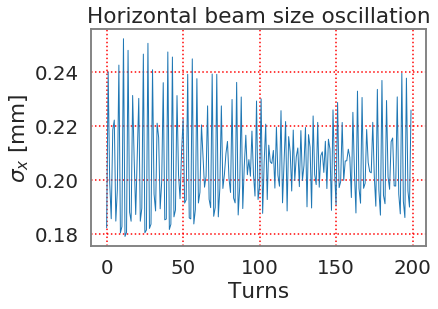

In [37]:
plt.plot(1e3 * sigma_x, lw=1)
plt.xlabel('Turns')
plt.ylabel('$\sigma_x$ [mm]')
plt.title('Horizontal beam size oscillation');

$\implies$ more complex kinetics than just a matrix ;-)

# ... well &ndash; let's try to unify, shan't we?

Integrating `SixTrackLib` tracking with wakefield kick from `PyHEADTAIL`

<center>
<img src="images/transverse-model_integration.png" alt="integrating PyHEADTAIL and SixTrackLib" style="width:30%;"/>
Alternating SixTrackLib <span style="color:#00aad4;">tracking</span> and PyHEADTAIL <span style="color:#aa0000;">kicking</span>
</center>

# The "starters" menu

1 turn $=$ `SixTrackLib` tracks complete ring + 1 `PyHEADTAIL` wakefield kick

$\implies$ flow control on python level (which library takes over when)

<!--* use `PyHEADTAIL` approach: python list of elements (NB: overhead quite small compared to `element.track` calls)
* utilise `SixTrackLib` API for tracking through all elements in one turn-->

### idea:

```python
for i in range(n_turns):
    # SixTrackLib:
    pyht_to_stl()
    trackjob.track_until(i)
    stl_to_pyht()
    # PyHEADTAIL
    wakefield.track(pyht_beam)
```

# Memory transfer

So how to define `pyht_to_stl()` and `stl_to_pyht()`?

Let's start with 
# A) `SixTrackLib` to `PyHEADTAIL`.

$\implies$ take a GPU memory pointer and construct a `PyCUDA.GPUArray`

In [38]:
# fresh restart with PyCUDA
driver.Context.pop()
context = driver.Device(0).make_context()

In [39]:
import pycuda.gpuarray as gp

In [40]:
def provide_pycuda_array(gpu_ptr, length):
    return gp.GPUArray(length, dtype=np.float64, gpudata=gpu_ptr)

# Approach

1. use `SixTrackLib`'s `CudaTrackJob` for the dedicated CUDA implementation $\implies$ stay in CUDA in both codes (no openCL)
2. prepare some GPU memory as an example in `SixTrackLib`
3. build a `PyCUDA` array around this memory for `PyHEADTAIL`

In [41]:
stl_beam = stl.Particles.from_ref(n_macroparticles)

In [42]:
type(stl_beam.x)

numpy.ndarray

In [43]:
stl_beam.x[:] = np.arange(0, 1, 1./n_macroparticles)

In [44]:
stl_beam.x[:10]

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009])

In [45]:
stl_ring_elements = stl.Elements.fromfile(
    stl_dir + '/../../tests/testdata/lhc_no_bb/beam_elements.bin')

# allocates GPU memory and fills it i.a. with the stl_beam.x array
cuda_trackjob = stl.CudaTrackJob(stl_ring_elements, stl_beam)

Retrieve location of `stl_beam.x` within particles buffer on GPU, i.e. memory pointer:

In [46]:
cuda_trackjob.fetch_particle_addresses()
ptrs = cuda_trackjob.get_particle_addresses()

In [47]:
ptrs.contents.x

140315499479216

In [48]:
x_gpu = provide_pycuda_array(ptrs.contents.x, n_macroparticles)

In [49]:
x_gpu[:10]

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009])

In [50]:
type(x_gpu)

pycuda.gpuarray.GPUArray

$\implies$ cool, we can construct a `PyCUDA` array from GPU memory &ndash; allocated and filled through `SixTrackLib`!

$\implies$ direction `SixTrackLib` to `PyHEADTAIL` is covered!

# B) `PyHEADTAIL` to `SixTrackLib`

The `GPUArrays` constructed during a `PyHEADTAIL` `track` call need not be the same memory location as before:

In [51]:
# simulate some tracking update:
x_pyht_tracked = x_gpu**2 + 1
x_pyht_tracked[:10]

array([1.      , 1.000001, 1.000004, 1.000009, 1.000016, 1.000025,
       1.000036, 1.000049, 1.000064, 1.000081])

In [52]:
assert int(x_pyht_tracked.gpudata) != int(x_gpu.gpudata)
int(x_pyht_tracked.gpudata), int(x_gpu.gpudata)

(140315499776000, 140315499479216)

$\implies$ copy the data back into the fixed buffer in `SixTrackLib`!

In [53]:
driver.memcpy_dtod(
    dest=ptrs.contents.x, 
    src=x_pyht_tracked.gpudata,
    size=x_pyht_tracked.nbytes
)

Let's check the buffer in `SixTrackLib` for the update:

In [54]:
provide_pycuda_array(ptrs.contents.x, n_macroparticles)[:10]

array([1.      , 1.000001, 1.000004, 1.000009, 1.000016, 1.000025,
       1.000036, 1.000049, 1.000064, 1.000081])

Transfer data within SixTrackLib back to CPU:

In [55]:
cuda_trackjob.collect_particles()

In [56]:
stl_beam.x[:10], type(stl_beam.x)

(array([1.      , 1.000001, 1.000004, 1.000009, 1.000016, 1.000025,
        1.000036, 1.000049, 1.000064, 1.000081]), numpy.ndarray)

$\implies$ indeed, the buffer has been filled with the updated values of `x`!

And we can collect the updated data back to the CPU memory from the GPU device!

# Finally &ndash; let's plug everything together!

Please: restart the notebook kernel to avoid the CUDA context mess.

In [1]:
from imports import *

from pycuda.autoinit import context
from pycuda import driver
import pycuda.gpuarray as gp

from PyHEADTAIL.general.contextmanager import GPU
from PyHEADTAIL.general import pmath
from PyHEADTAIL.impedances.wakes import WakeField, CircularResonator
from PyHEADTAIL.particles.slicing import UniformBinSlicer
import pyht_streamless_slicing
from PyHEADTAIL.particles.generators import generate_Gaussian6DTwiss

import sixtracklib as stl

import os
stl_dir = os.path.dirname(stl.__file__)

from pyheadtail_setup import beam_kwargs
from scipy.constants import m_p, c, e

def provide_pycuda_array(gpu_ptr, length):
    return gp.GPUArray(length, dtype=np.float64, gpudata=gpu_ptr)

PyHEADTAIL v1.14.1.21




## The beam (containers):

In [2]:
n_macroparticles = 10000
intensity = 1e11 * 50

np.random.seed(0)

pyht_beam = generate_Gaussian6DTwiss(
    macroparticlenumber=n_macroparticles,
    intensity=intensity,
    # the injection optics for this LHC lattice:
    alpha_x=2.2,
    beta_x=117,
    dispersion_x=-0.41,
    alpha_y=-2.7,
    beta_y=218,
    dispersion_y=-0.047,
    **beam_kwargs,
)

In [3]:
stl_beam = stl.Particles.from_ref(
    n_macroparticles, p0c=pyht_beam.p0 * c / e, 
    mass0=pyht_beam.mass * c**2 / e, q0=1)

## The accelerator:

In [4]:
# SixTrackLib tracking part:
stl_ring_elements = stl.Elements.fromfile(
    stl_dir + '/../../tests/testdata/lhc_no_bb/beam_elements.bin')

cuda_trackjob = stl.CudaTrackJob(stl_ring_elements, stl_beam)

In [5]:
# PyHEADTAIL wakefield kick part:
slicer = UniformBinSlicer(n_slices=50, n_sigma_z=4)
resonator_wake = CircularResonator(R_shunt=100e6, frequency=0.8e9, Q=1)
wakefield = WakeField(slicer, resonator_wake)

## Preparation for the GPU device data transfers:

Storing the `SixTrackLib` buffer pointers:

In [6]:
cuda_trackjob.fetch_particle_addresses()
ptrs = cuda_trackjob.get_particle_addresses()

pointers = {
    'x': provide_pycuda_array(ptrs.contents.x, n_macroparticles),
    'px': provide_pycuda_array(ptrs.contents.px, n_macroparticles),
    'y': provide_pycuda_array(ptrs.contents.y, n_macroparticles),
    'py': provide_pycuda_array(ptrs.contents.py, n_macroparticles),
    'z': provide_pycuda_array(ptrs.contents.zeta, n_macroparticles),
    'delta': provide_pycuda_array(ptrs.contents.delta, n_macroparticles),
    'rpp': provide_pycuda_array(ptrs.contents.rpp, n_macroparticles),
    'psigma': provide_pycuda_array(ptrs.contents.psigma, n_macroparticles),
    'rvv': provide_pycuda_array(ptrs.contents.rvv, n_macroparticles),
}

In [7]:
def memcpy(dest, src):
    '''Device memory copy from GPUArray src to GPUArray dest.'''
    driver.memcpy_dtod_async(dest.gpudata, src.gpudata, src.nbytes)

Function for `PyHEADTAIL` to `SixTrackLib` memory transfer:

In [8]:
from pycuda import cumath

def pyht_to_stl(pyht_beam):
    memcpy(pointers['x'], pyht_beam.x)
    memcpy(pointers['px'], pyht_beam.xp)
    memcpy(pointers['y'], pyht_beam.y)
    memcpy(pointers['py'], pyht_beam.yp)
    memcpy(pointers['z'], pyht_beam.z)
    memcpy(pointers['delta'], pyht_beam.dp)

    # further longitudinal coordinates of SixTrackLib
    rpp = 1. / (pyht_beam.dp + 1)

    restmass = pyht_beam.mass * c**2
    restmass_sq = restmass**2
    E0 = np.sqrt((pyht_beam.p0 * c)**2 + restmass_sq)
    p = pyht_beam.p0 * (1 + pyht_beam.dp)
    E = cumath.sqrt((p * c) * (p * c) + restmass_sq)
    psigma =  (E - E0) / (pyht_beam.beta * pyht_beam.p0 * c)

    gamma = E / restmass
    beta = cumath.sqrt(1 - 1. / (gamma * gamma))
    rvv = beta / pyht_beam.beta

    memcpy(pointers['rpp'], rpp)
    memcpy(pointers['psigma'], psigma)
    memcpy(pointers['rvv'], rvv)
    
    # PyCUDA context:
    context.synchronize()

Function for `SixTrackLib` to `PyHEADTAIL` memory transfer:

In [9]:
def stl_to_pyht(pyht_beam):
    # barrier to make sure any previous
    # SixTrackLib kernels have finished 
    cuda_trackjob.collect()
    
    pyht_beam.x = pointers['x']
    pyht_beam.xp = pointers['px']
    pyht_beam.y = pointers['y']
    pyht_beam.yp = pointers['py']
    pyht_beam.z = pointers['z']
    pyht_beam.dp = pointers['delta']

## Ready for tracking:

In [10]:
n_turns = 11

with GPU(pyht_beam):
    my = pmath.zeros(n_turns, dtype=float)
    
    for i in range(n_turns):
        # SixTrackLib:
        pyht_to_stl(pyht_beam)
        cuda_trackjob.track_until(i)
        stl_to_pyht(pyht_beam)
        # PyHEADTAIL
        wakefield.track(pyht_beam)
        
        # record vertical bunch centroid amplitude
        my[i] = pyht_beam.mean_y()

In [11]:
my = pmath.ensure_CPU(my)

# Simulation Results

$\implies$ strong instability, this time with realistic lattice:

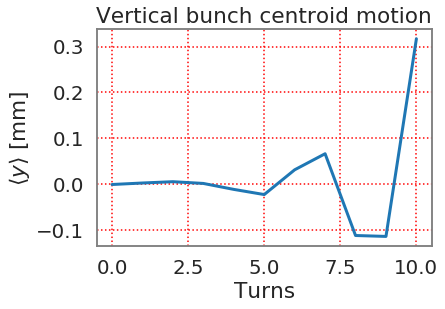

In [12]:
plt.plot(my * 1e3)
plt.xlabel('Turns')
plt.ylabel(r'$\langle y \rangle$ [mm]')
plt.title('Vertical bunch centroid motion');

Along with the same type of displacement pattern along the bunch:

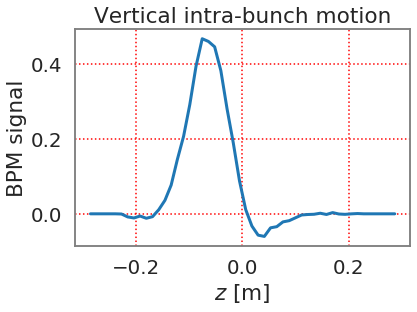

In [14]:
slices = pyht_beam.get_slices(slicer, statistics=True)
plt.plot(slices.z_centers, slices.mean_y * slices.n_macroparticles_per_slice)
plt.xlabel('$z$ [m]')
plt.ylabel('BPM signal')
plt.title('Vertical intra-bunch motion');

# ... Summary!